#### Data Exploration on four data sets provided: cold_start_test, consumption_train, meta, submission_format

In [380]:
import os
import numpy as np
import datetime
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from pandas import Series
from matplotlib import pyplot
from collections import Counter
from datetime import date
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5] 
#from fbprophet import Prophet
from scipy.stats import mode
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression, Ridge, Lasso,  RidgeCV 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [269]:
#test = pd.read_csv("Data/test-data.csv", delimiter=';')

test = pd.read_csv("Data/test-data.csv", parse_dates=['timestamp'], delimiter=';') #hourly time step

#train = pd.read_csv("Data/training-data.csv",delimiter=';')
train = pd.read_csv("Data/training-data.csv",  parse_dates=['timestamp'],delimiter=';')

#metadata = pd.read_csv("Data/metadata.csv", delimiter=';')
metadata = pd.read_csv("Data/metadata.csv",  delimiter=';')

#format = pd.read_csv("Data/submission-format.csv", index_col='timestamp', delimiter=';')
format = pd.read_csv("Data/submission-format.csv", parse_dates=['timestamp'], index_col='pred_id', delimiter=';')

In [270]:
type(train)

pandas.core.frame.DataFrame

In [273]:
test.head()


,series_id,timestamp,consumption,temperature
0,101047,2016-03-06 08:00:00-05:00,4794.353543,10.977273
1,100203,2017-01-25 12:00:00-05:00,9011.298540,7.909091
2,100203,2017-01-25 15:00:00-05:00,6608.533944,2.900000
3,100203,2017-01-27 07:00:00-05:00,8892.091614,6.272727
4,100203,2017-01-27 13:00:00-05:00,9756.341826,4.272727


In [140]:
train.describe()

,series_id,consumption,temperature
count,509376.000000,5.093760e+05,280687.000000
mean,101851.234828,1.076238e+05,15.188679
std,1020.487674,1.626611e+05,8.987142
min,100003.000000,0.000000e+00,-13.466667
25%,100998.000000,1.542092e+04,8.451190
50%,101884.500000,4.986205e+04,15.163333
75%,102697.000000,1.351661e+05,21.800000
max,103634.000000,2.085109e+06,44.350000


In [141]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 10 columns):
series_id               1383 non-null int64
surface                 1383 non-null object
base_temperature        1383 non-null object
monday_is_day_off       1383 non-null bool
tuesday_is_day_off      1383 non-null bool
wednesday_is_day_off    1383 non-null bool
thursday_is_day_off     1383 non-null bool
friday_is_day_off       1383 non-null bool
saturday_is_day_off     1383 non-null bool
sunday_is_day_off       1383 non-null bool
dtypes: bool(7), int64(1), object(2)
memory usage: 41.9+ KB


In [142]:
metadata.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100020,medium,low,False,False,False,False,False,True,True
1,100111,small,low,False,False,False,False,False,True,True
2,100350,xx-large,low,False,False,False,False,False,True,True
3,100351,x-large,low,False,False,False,False,False,True,True
4,100354,xx-large,low,False,False,False,False,True,True,True


In [143]:
metadata['sunday_is_day_off'].value_counts()

True     1274
False     109
Name: sunday_is_day_off, dtype: int64

In [144]:
surface = metadata.surface
print(np.unique(surface))
base = metadata.base_temperature 
print(np.unique(base))

['large' 'medium' 'small' 'x-large' 'x-small' 'xx-large' 'xx-small']
['high' 'low']


In [146]:
format.head()

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
80,103578,2013-01-09 19:00:00-05:00,22.022917,0.0,daily
79,103578,2013-01-08 19:00:00-05:00,20.654167,0.0,daily
130,103626,2014-05-25 14:00:00-04:00,15.850000,0.0,hourly
133,103626,2014-05-25 17:00:00-04:00,14.750000,0.0,hourly
62,103268,2015-04-23 03:00:00-04:00,13.000000,0.0,hourly


### Start of training and metadata data sets being combined

In [147]:
train_meta = pd.merge(train,
                 metadata,
                 on='series_id', how = 'outer')
#train_meta['timestamp'] = pd.to_datetime(train_meta['timestamp'])

train_meta.describe()


,series_id,consumption,temperature
count,510001.000000,5.093760e+05,280687.000000
mean,101851.244394,1.076238e+05,15.188679
std,1020.564457,1.626611e+05,8.987142
min,100003.000000,0.000000e+00,-13.466667
25%,100998.000000,1.542092e+04,8.451190
50%,101884.000000,4.986205e+04,15.163333
75%,102697.000000,1.351661e+05,21.800000
max,103634.000000,2.085109e+06,44.350000


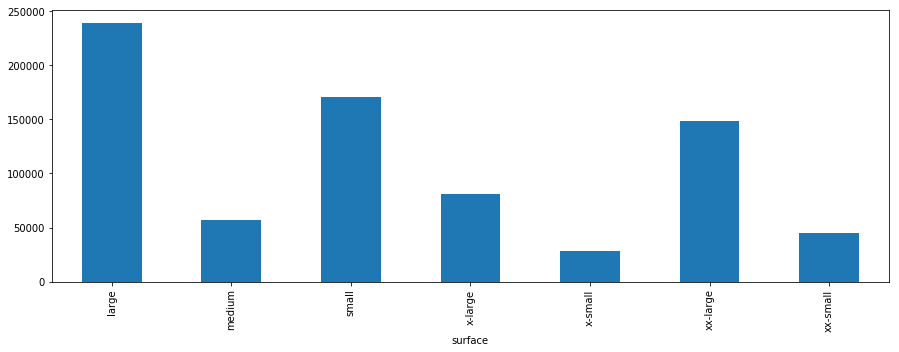

In [274]:
train_meta.groupby('surface').consumption.mean().plot(kind='bar')

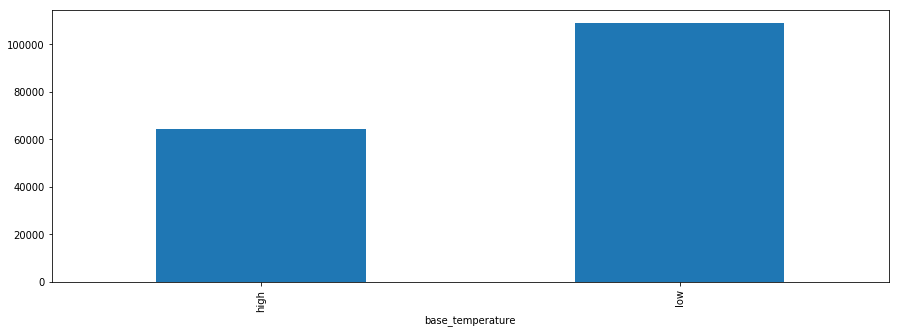

In [149]:
train_meta.groupby('base_temperature').consumption.mean().plot(kind='bar')

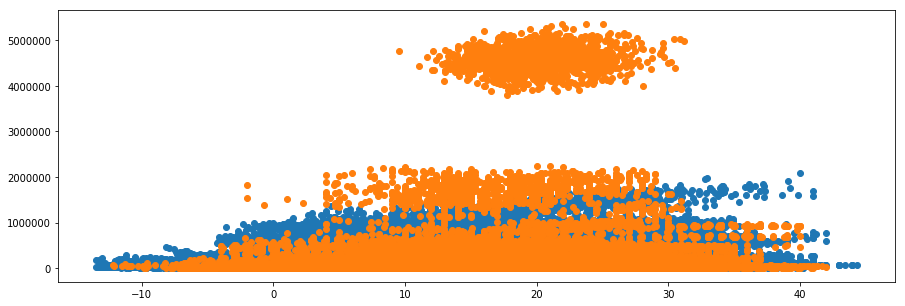

In [278]:
plt.scatter( train_meta.temperature, train_meta.consumption)
plt.scatter( test.temperature, test.consumption) #orange 
#good predictor - whether or not it is a weekend (add column to both data sets to say whether or not it is a weekend )

In [151]:
#plt.plot(train_meta['timestamp'], train_meta['consumption'])

#is this a collection of more data or are buildings consuming more? 
#null temp - use average of next season to fill in gaps
#look at how many buildings have missing data and if there is a pattern in the missing data
#throw out buildings with few points compared to other
#what resolution makes the most sense
#how many buildings have a daily record vs hourly, etc. 
#resample fcn from datetimp capabilities 
#groupby building size, instead of predicting individual buildings
#groupby building size and plot temp 


In [354]:
#turning weekday to 0 1 
#return 1 if less than 5, 0 otherwise

train_meta.loc[:,'dayofweek'] = train_meta.index.weekday


In [362]:
def weekend_fcn(x):
    if x <= 4:
        return 1
    else:
        return 0
        
train_meta.loc[:,'isweekday'] = train_meta.loc[:,'dayofweek'].apply(lambda x: weekend_fcn(x))

In [365]:
test.loc[:,'dayofweek'] = test.index.weekday
        
test.loc[:,'isweekday'] = test.loc[:,'dayofweek'].apply(lambda x: weekend_fcn(x))

In [366]:
test.head()

,series_id,consumption,temperature,dayofweek,isweekday
timestamp,,,,,
2016-03-06 13:00:00+00:00,101047,4794.353543,10.977273,6,0
2017-01-25 17:00:00+00:00,100203,9011.298540,7.909091,2,1
2017-01-25 20:00:00+00:00,100203,6608.533944,2.900000,2,1
2017-01-27 12:00:00+00:00,100203,8892.091614,6.272727,4,1
2017-01-27 18:00:00+00:00,100203,9756.341826,4.272727,4,1


In [363]:
train_meta.head()
#look at seasonality - is there a pattern in days of the week?
#spring vs fall, etc.
#surface type in a different color
#potentially different model for different sizes
#

,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,surface_num,dayofweek,isweekday
timestamp,,,,,,,,,,,,,,,
2015-04-05 13:00:00+00:00,102838,24503.324916,13.416667,xx-large,low,False,False,False,False,False,True,True,6,6,0
2015-04-05 15:00:00+00:00,102838,26592.524360,13.000000,xx-large,low,False,False,False,False,False,True,True,6,6,0
2015-03-11 10:00:00+00:00,102838,116047.567727,11.833333,xx-large,low,False,False,False,False,False,True,True,6,2,1
2015-03-17 13:00:00+00:00,102838,105676.184769,14.416667,xx-large,low,False,False,False,False,False,True,True,6,1,1
2015-03-18 14:00:00+00:00,102838,85336.335890,16.000000,xx-large,low,False,False,False,False,False,True,True,6,2,1


In [153]:
buildings_train = train.series_id
print('Training data set unique buildings:', len(set(buildings_train)))
buildings_test = test.series_id
print('Testing data set unique buildings:', len(set(buildings_test)))


Training data set unique buildings: 758
Testing data set unique buildings: 625


In [154]:
train_meta.dropna(subset=['timestamp', 'temperature'],how='any',inplace=True) 

## first set timestamp as our index. 

In [282]:
train_meta.set_index('timestamp',inplace=True)
test.set_index('timestamp',inplace=True)

In [284]:
test.head()

,series_id,consumption,temperature
timestamp,,,
2016-03-06 08:00:00-05:00,101047,4794.353543,10.977273
2017-01-25 12:00:00-05:00,100203,9011.298540,7.909091
2017-01-25 15:00:00-05:00,100203,6608.533944,2.900000
2017-01-27 07:00:00-05:00,100203,8892.091614,6.272727
2017-01-27 13:00:00-05:00,100203,9756.341826,4.272727


## look at per building counts

In [159]:
# this is great. it shows us that there are lots of series ID without any entries. 
by_series = train_meta.groupby('series_id').count() #Each building has 672 timestamp entries, but I want to figure out how often. Daily, hourly, etc? 
#keep only buildings with at least one temp reading.
has_temp = by_series[by_series.temperature>=1]

In [160]:
has_temp.head()

,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
series_id,,,,,,,,,,,
100003,432,432,432,432,432,432,432,432,432,432,432
100017,672,672,672,672,672,672,672,672,672,672,672
100027,672,672,672,672,672,672,672,672,672,672,672
100033,12,12,12,12,12,12,12,12,12,12,12
100036,672,672,672,672,672,672,672,672,672,672,672


In [161]:
# what might make more sense, is to get the daily sum for each building, then get rid of buildings with more than 10 days (or whatever) of missing data. 

## plot rates of consumption


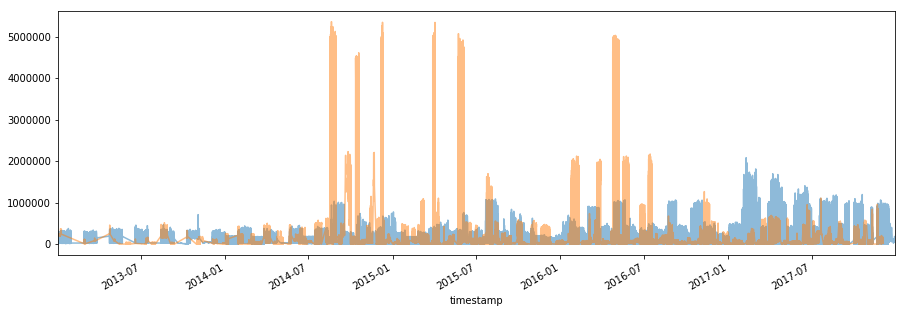

In [401]:
data = train_meta.consumption
# raw data plot
data.plot(alpha=0.5, style='-', label='Training')

data_test = test.consumption
data_test.plot(alpha=0.5, style='-', label = 'Test')


data.index = pd.to_datetime(data.index, utc=True)
data_test.index = pd.to_datetime(data_test.index, utc=True)

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


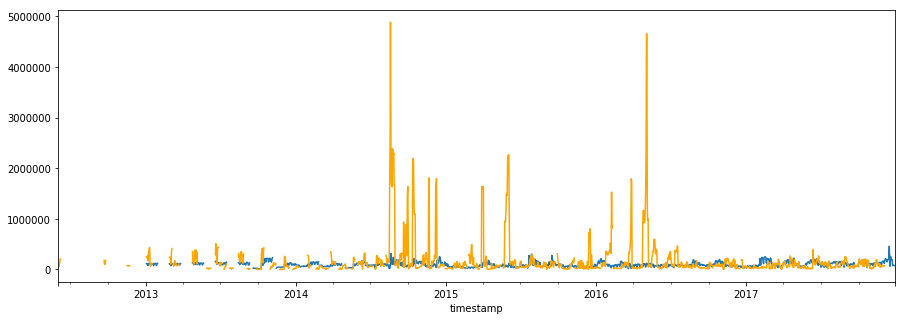

In [344]:
# resample by taking the daily consumption mean
data.resample('D').mean().plot(style='-')
data_test.resample('D').mean().plot(style='-',color='orange')
#plot consumption by temperature. 1D LR with consumption (y) temperature (x)

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


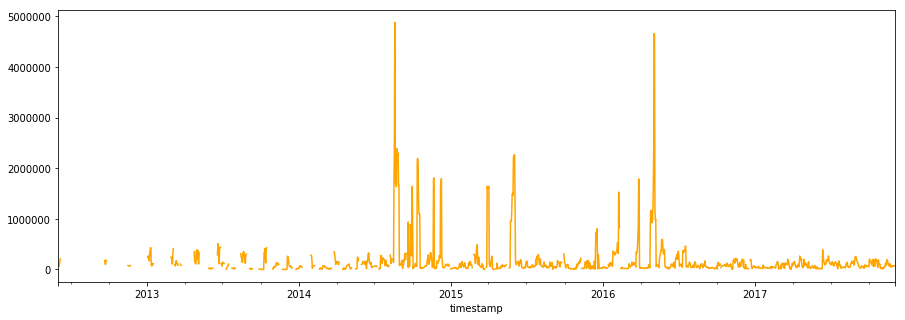

In [304]:
data_test.resample('D').mean().plot(style='-',color='orange')

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


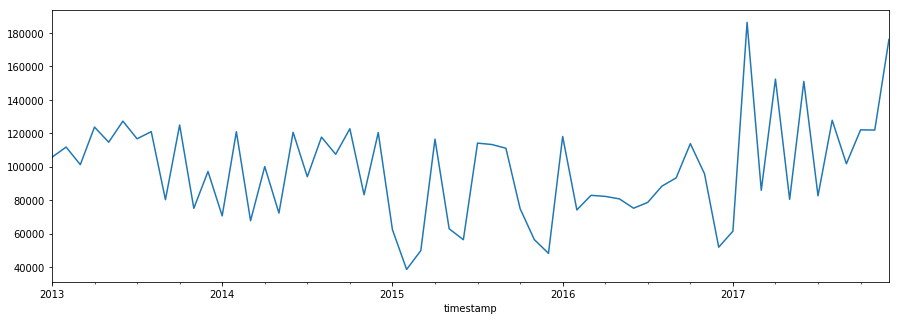

In [167]:
# resample by taking the monthly consumption mean
data.resample('M').mean().plot(style='-');

## temperature 

In [306]:
train_meta.index = pd.to_datetime(train_meta.index, utc=True)
test.index = pd.to_datetime(test.index,utc=True)

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


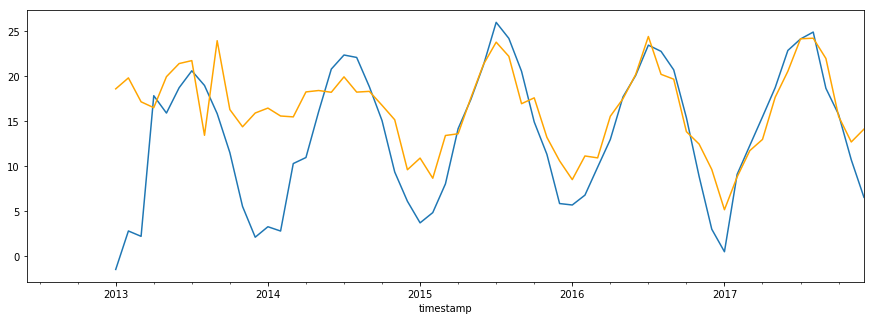

In [312]:
# notice the seasonality in the temperatures here. we don't really see this in the consumption data at the aggregate mean level. 
train_meta.temperature.resample('M').mean().plot(style='-')
test.temperature.resample('M').mean().plot(style='-', color='orange')

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


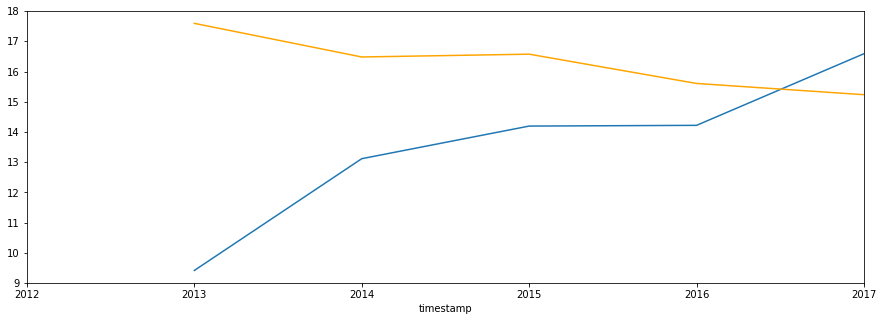

In [311]:
# we do see an overall increase in yearly temp 
train_meta.temperature.resample('A').mean().plot(style='-');
test.temperature.resample('A').mean().plot(style='-', color='orange')

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


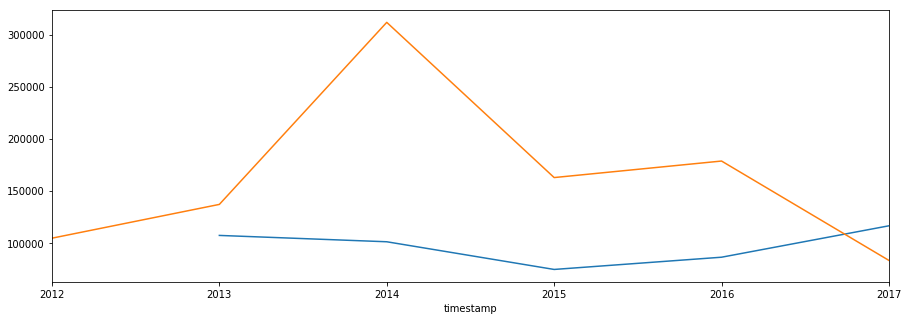

In [310]:
# and a pretty uncorrelated decrease and then increase in mean consumption (yearly)
data.resample('A').mean().plot(style='-');
data_test.resample('A').mean().plot(style='-');

# by surface category
now we will make new columns (one for each line we want to plot like x-small, large, etc)
then it will plot each column as a different line. 

In [88]:
#train_meta = train_meta.loc[train_meta.index.dropna()]
train_meta.head()

,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
timestamp,,,,,,,,,,,,
2015-04-05 13:00:00+00:00,102838,24503.324916,13.416667,xx-large,low,False,False,False,False,False,True,True
2015-04-05 15:00:00+00:00,102838,26592.524360,13.000000,xx-large,low,False,False,False,False,False,True,True
2015-03-11 10:00:00+00:00,102838,116047.567727,11.833333,xx-large,low,False,False,False,False,False,True,True
2015-03-17 13:00:00+00:00,102838,105676.184769,14.416667,xx-large,low,False,False,False,False,False,True,True
2015-03-18 14:00:00+00:00,102838,85336.335890,16.000000,xx-large,low,False,False,False,False,False,True,True


In [172]:
# get the daily total for each type, and put into a daily consumption table. 

def daily_sum(df,surface_type):
    ''' df = dataframe, measure = the column you want to include i.e. consumption, surface_type=variable in the surface column you are selecting'''
    
    newdf = df[df.surface==surface_type].resample('D').sum()
    newdf_c=pd.DataFrame()
    newdf_c[surface_type] = newdf.consumption
    return newdf_c

In [173]:
xxsmall_con = daily_sum(train_meta,'xx-small')
xsmall_con = daily_sum(train_meta,'x-small')
small_con = daily_sum(train_meta, 'small')
medium_con = daily_sum(train_meta,'medium')
large_con = daily_sum(train_meta,'large')
xlarge_con = daily_sum(train_meta,'x-large')
xxlarge_con = daily_sum(train_meta,'xx-large')

In [174]:
surface_consumption = pd.merge(xxsmall_con,xsmall_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,small_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,medium_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,large_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,xlarge_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,xxlarge_con, right_index=True,left_index=True)

surface_consumption.head()

,xx-small,x-small,small,medium,large,x-large,xx-large
timestamp,,,,,,,
2016-01-24 00:00:00+00:00,0.000000,0.000000,7.118566e+05,1.667639e+06,7.558571e+06,2.229414e+05,0.0
2016-01-25 00:00:00+00:00,0.000000,310258.829235,5.263797e+06,2.801335e+06,9.412651e+06,3.819413e+06,0.0
2016-01-26 00:00:00+00:00,913820.782653,301663.800209,7.133986e+06,2.758980e+06,8.718243e+06,3.987499e+06,0.0
2016-01-27 00:00:00+00:00,850558.149467,311529.683726,6.797021e+06,2.689985e+06,8.582801e+06,8.962491e+06,0.0
2016-01-28 00:00:00+00:00,916145.715014,315799.650701,7.480217e+06,8.977507e+05,8.708509e+06,9.067872e+06,0.0


C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


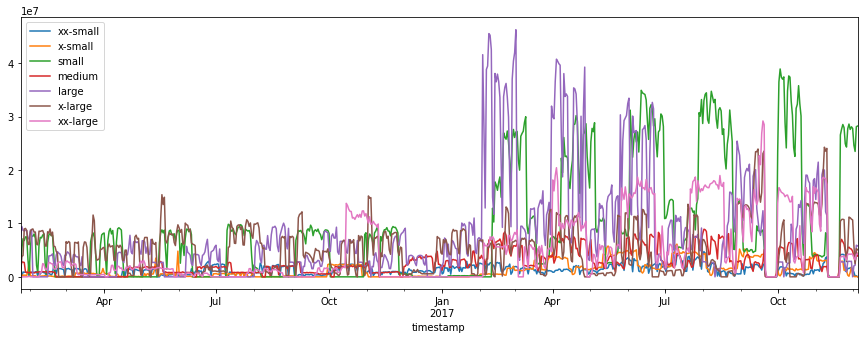

In [175]:
# now we can see the totals for each category in whatever freq we like.  
surface_consumption.resample('D').sum().plot();

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


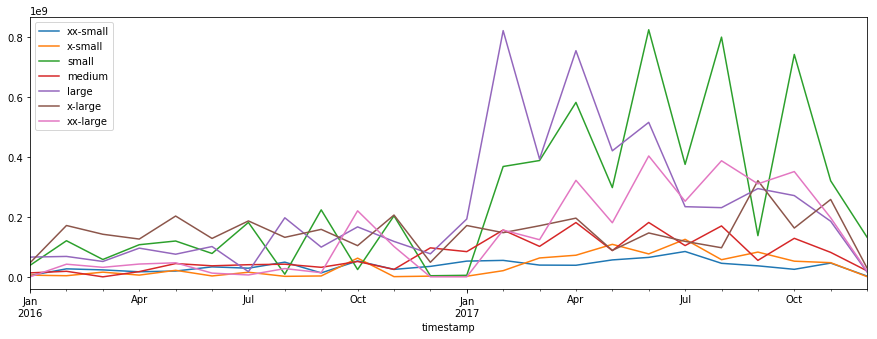

In [176]:
surface_consumption.resample('M').sum().plot();

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


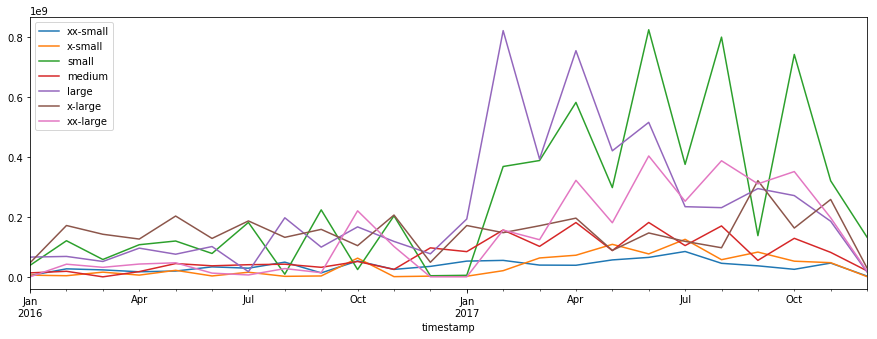

In [177]:
surface_consumption.resample('M').sum().plot();

 here's how we can use a groupby to get the day of week, you could do the same with months or years, or even time of day (but you have to go back to before you resampled to daily)

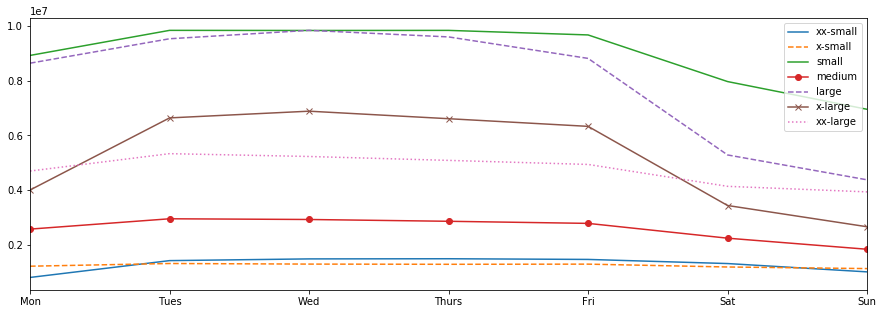

In [313]:
by_weekday = surface_consumption.groupby(surface_consumption.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', '-','o-','--','x-',':']);

 see how consumption goes down on the weekends? 

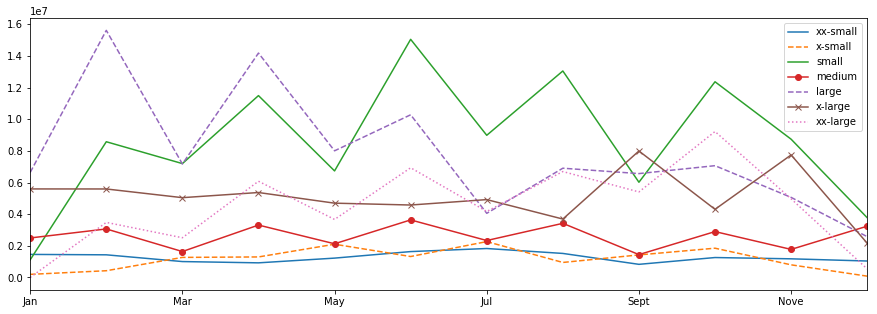

In [314]:
by_month = surface_consumption.groupby(surface_consumption.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'Ap','May', 'Jun', 'Jul', 'Aug','Sept','Oct','Nove','Dec']
by_month.plot(style=['-', '--', '-','o-','--','x-',':']);

# now for temps

In [315]:
# get the daily total for each type, and put into a daily consumption table. 

def daily_sum_t(df,surface_type):
    ''' df = dataframe, measure = the column you want to include i.e. consumption, surface_type=variable in the surface column you are selecting'''
    
    newdf = df[df.surface==surface_type].resample('D').sum()
    newdf_c=pd.DataFrame()
    newdf_c[surface_type] = newdf.temperature
    return newdf_c

In [316]:
xxsmall_temp = daily_sum_t(train_meta,'xx-small')
xsmall_temp = daily_sum_t(train_meta,'x-small')
small_temp = daily_sum_t(train_meta, 'small')
medium_temp = daily_sum_t(train_meta,'medium')
large_temp = daily_sum_t(train_meta,'large')
xlarge_temp = daily_sum_t(train_meta,'x-large')
xxlarge_temp = daily_sum_t(train_meta,'xx-large')

In [317]:
surface_temp = pd.merge(xxsmall_temp,xsmall_temp, right_index=True,left_index=True)
surface_temp = pd.merge(surface_temp,small_temp, right_index=True,left_index=True)
surface_temp = pd.merge(surface_temp,medium_temp, right_index=True,left_index=True)
surface_temp = pd.merge(surface_temp,large_temp, right_index=True,left_index=True)
surface_temp = pd.merge(surface_temp,xlarge_temp, right_index=True,left_index=True)
surface_temp = pd.merge(surface_temp,xxlarge_temp, right_index=True,left_index=True)

surface_temp.head()

,xx-small,x-small,small,medium,large,x-large,xx-large
timestamp,,,,,,,
2016-01-24 00:00:00+00:00,0.000000,0.0,21.466667,72.550000,273.108333,18.150000,0.0
2016-01-25 00:00:00+00:00,0.000000,38.9,38.900000,230.600000,318.600000,192.754103,0.0
2016-01-26 00:00:00+00:00,86.400000,66.4,66.400000,372.266667,308.300000,340.421212,0.0
2016-01-27 00:00:00+00:00,155.116667,84.2,84.200000,360.966667,323.691667,496.052424,0.0
2016-01-28 00:00:00+00:00,135.966667,130.8,130.800000,200.166667,296.325000,827.594742,0.0


C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


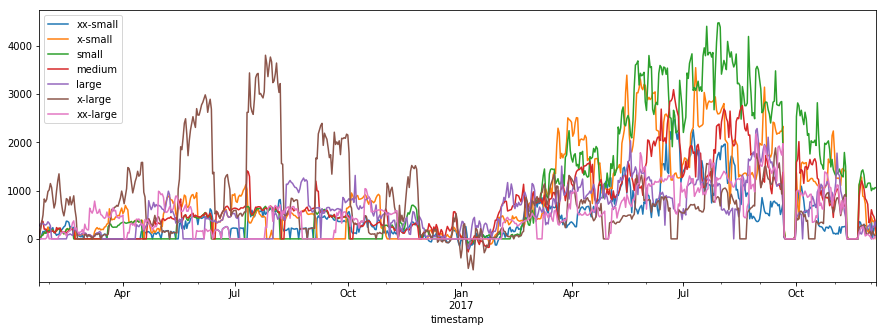

In [318]:
surface_temp.resample('D').mean().plot();

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


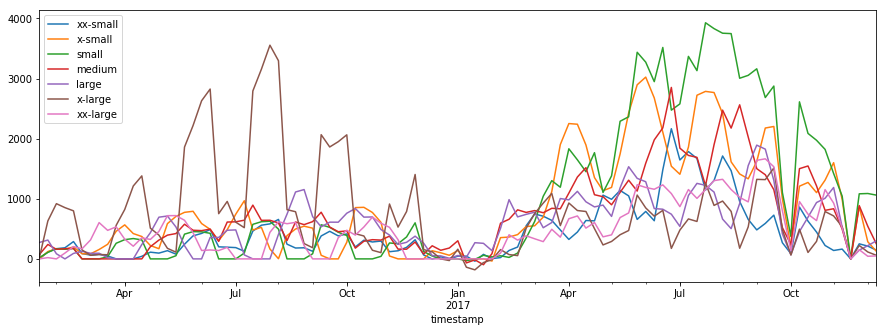

In [319]:
surface_temp.resample('W').mean().plot();

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


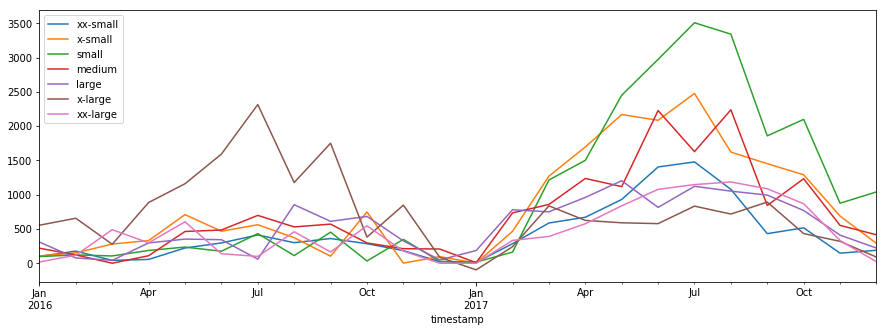

In [320]:
surface_temp.resample('M').mean().plot();

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


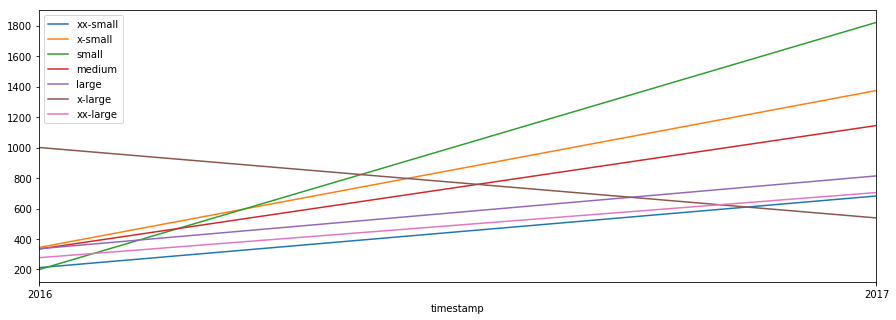

In [321]:
surface_temp.resample('A').mean().plot();

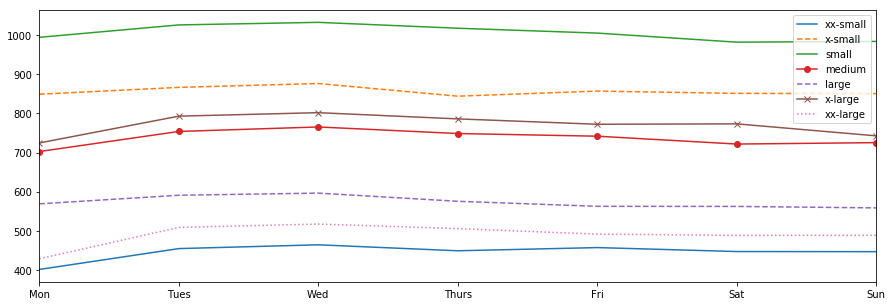

In [322]:
by_weekday = surface_temp.groupby(surface_temp.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', '-','o-','--','x-',':']);

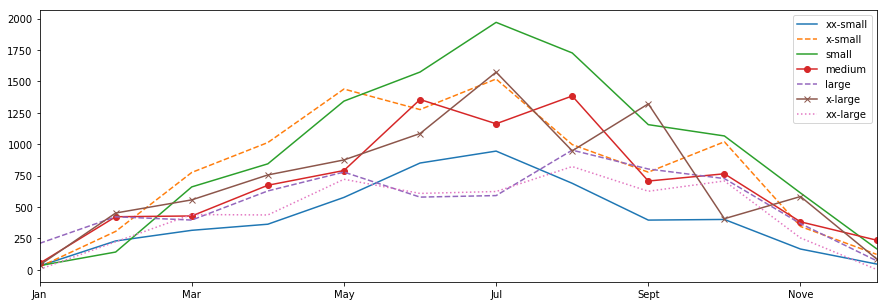

In [323]:
by_month = surface_temp.groupby(surface_temp.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'Ap','May', 'Jun', 'Jul', 'Aug','Sept','Oct','Nove','Dec']
by_month.plot(style=['-', '--', '-','o-','--','x-',':']);

Now. You just need to see if you can get a list of all the buildings that have less than 10 days of
temperature recordings (or whatever threshold makes sense). 
You already have this, when you do the groupby seriesid. 
Then, go back and  drop all the entries for those buildings from the main matrix,
resample the data again and see if it changes.  
It shouldn’t b/c the resampling we already did is going to just drop any NaNs. 
And most of them should be b/c they don’t have data from the early years. 
If that’s the case, leave it in.  if there is intermittent data for a building, throw it out.

However,  if there is at least one number per day (b/c in the format csv, they want us to predict daily consumption) or only a few days missing, then you can just interpolate from the day before or after.  The quick and dirty way to do this is with .ffil() and .bbfill(). In pandas. But you will want to take a look at as many as possible before making that decision. i.e. plot them in batches of 100 or something. 
 
 


In [404]:
#has_10temp = train_meta.groupby('series_id').filter(lambda temperature : len(temperature)>10)
#has_10temp.head()

#get missing temperature data from weather API 

has_temp = train_meta.groupby('series_id')
has_temp = has_temp.filter(lambda x: x['temperature'].count() > 10.) #what percentage sounds acceptable 

has_temp.head()
has_temp.isna().sum()

#see if there is a trend within 243 with more than 10 missing temp values, drop 
#top buildings with missing data 

nohas_temp = has_temp[has_temp.temperature.isna()]
nohas_temp.sort_values(by='series_id')
nohas_temp.series_id.describe()
#nohas_temp.set_index("timestamp", inplace=True)
#nohas_temp[['temperature']].plot(); #throw this one building out 


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: series_id, dtype: float64

In [402]:
has_10temp = train_meta.groupby(['series_id', 'consumption']).temperature.count()[lambda x: x >= 10]
has_10temp

series_id  consumption 
100003     1.879700e+05     23
           1.910017e+05     52
           1.940335e+05     56
           1.970653e+05     52
           2.000970e+05     30
           2.061606e+05     16
           2.364783e+05     11
           2.425419e+05     16
           2.455737e+05     15
           2.486054e+05     23
           2.516372e+05     12
           2.546690e+05     10
100027     4.881229e+02     35
           4.997449e+02     68
           5.113669e+02     15
           8.484041e+02     30
           8.600261e+02     58
           8.716481e+02     70
           8.832701e+02     15
100046     6.752064e+00     50
           1.012810e+01    128
           2.025619e+01     16
           3.376032e+01     15
           7.427270e+01     80
           7.764873e+01     63
           8.440080e+01     10
100139     9.379959e+04     78
           9.848957e+04     42
           1.031796e+05     17
           1.078695e+05     11
                          ... 
103536     2.63

### Holt-Winters Method

In [ ]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['consumption']) ,seasonal_periods=4 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['consumption'], label='Train')
plt.plot(test['consumption'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
#took too long so I killed it 

### Simple exponential smoothing

In [ ]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['consumption'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['consumption'], label='Train')
plt.plot(test['consumption'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

#bias variance tradeoff 
#start with a linear regression
#think about triangle - speed, inter, accuracy 
#start with auto regressive, then ARIMA, FFT, LSTM 


### Holt's linear trend

In [ ]:
freq = train_meta.index.inferred_freq
if freq is not None:
    freq = index.inferred_freq
#decomposed = sm.tsa.seasonal_decompose(np.asarray(dta), freq=3)

train_copy = train.copy()
train_copy = train_copy.set_index(pd.to_datetime(train_copy.index))
import statsmodels.api as sm
sm.tsa.seasonal_decompose(np.asarray(train.consumption),freq=3).plot()
result = sm.tsa.stattools.adfuller(train.consumption)
plt.show()

### linear regression

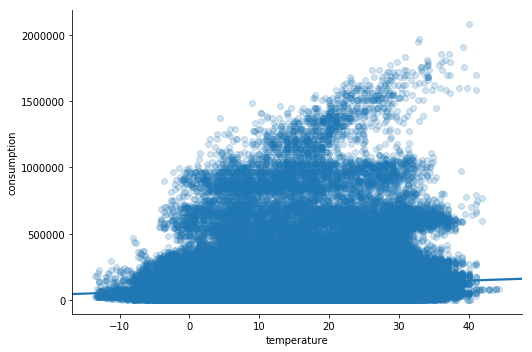

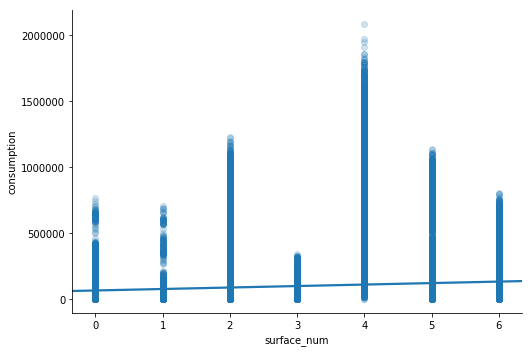

In [211]:
sns.lmplot(x='temperature', y='consumption', data=train_meta, aspect=1.5, scatter_kws={'alpha':0.2});
sns.lmplot(x='surface_num', y='consumption', data=train_meta, aspect=1.5, scatter_kws={'alpha':0.2});

In [195]:
train_meta.surface.unique()

array(['xx-large', 'x-large', 'x-small', 'xx-small', 'large', 'medium',
       'small'], dtype=object)

In [207]:
train_meta.head()

,timestamp,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,surface_num
0,2015-04-05 13:00:00+00:00,102838,24503.324916,13.416667,xx-large,low,False,False,False,False,False,True,True,6
1,2015-04-05 15:00:00+00:00,102838,26592.524360,13.000000,xx-large,low,False,False,False,False,False,True,True,6
2,2015-03-11 10:00:00+00:00,102838,116047.567727,11.833333,xx-large,low,False,False,False,False,False,True,True,6
3,2015-03-17 13:00:00+00:00,102838,105676.184769,14.416667,xx-large,low,False,False,False,False,False,True,True,6
4,2015-03-18 14:00:00+00:00,102838,85336.335890,16.000000,xx-large,low,False,False,False,False,False,True,True,6


In [210]:
test.head() #how do I use this test data set 

,series_id,consumption,temperature
timestamp,,,
2016-03-06 08:00:00-05:00,101047,4794.353543,10.977273
2017-01-25 12:00:00-05:00,100203,9011.298540,7.909091
2017-01-25 15:00:00-05:00,100203,6608.533944,2.900000
2017-01-27 07:00:00-05:00,100203,8892.091614,6.272727
2017-01-27 13:00:00-05:00,100203,9756.341826,4.272727


In [198]:
train_meta['surface_num'] = train_meta.surface.map({'xx-small':0, 'x-small':1, 'small':2, 'medium':3, 'large':4, 'x-large':5, 'xx-large':6})
# test['surface_num'] = test.surface.map({'xx-small':0, 'x-small':1, 'small':2, 'medium':3, 'large':4, 'x-large':5, 'xx-large':6})

In [199]:
train_meta[['consumption', 'surface_num', 'temperature']].corr()

,consumption,surface_num,temperature
consumption,1.000000,0.130524,0.099456
surface_num,0.130524,1.000000,-0.132413
temperature,0.099456,-0.132413,1.000000


In [325]:
#feature_cols = ['surface_num', 'temperature']
#X = train_meta[feature_cols]
#y = train_meta.consumption

feature_cols = 'temperature'
X = np.array(train_meta.loc[:,[feature_cols]])
y =np.array(train_meta.loc[:,'consumption']



SyntaxError: unexpected EOF while parsing (<ipython-input-325-5fc5dfe21404>, line 8)

In [228]:
print(X.shape)
print(y.shape)

(280687, 2)
(280687,)


In [229]:
lr=LinearRegression()
train_meta = train_meta.reset_index()

In [230]:
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [231]:
print(lr.intercept_)
list(zip(feature_cols, lr.coef_))

28609.583941072444


[('surface_num', 12547.32683356806), ('temperature', 2133.802768400626)]

In [337]:
def train_test_rmse(feature_cols):
    
    #X_train = train_meta[feature_cols]
    #y_train = train_meta.consumption
    
    X = np.array(train_meta.loc[:,feature_cols])
    y =np.array(train_meta.loc[:,'consumption'])
                
    X_test = test[feature_cols]
    y_test = test.consumption
    
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [376]:
train_meta.isna().sum()

series_id               0
consumption             0
temperature             0
surface                 0
base_temperature        0
monday_is_day_off       0
tuesday_is_day_off      0
wednesday_is_day_off    0
thursday_is_day_off     0
friday_is_day_off       0
saturday_is_day_off     0
sunday_is_day_off       0
surface_num             0
dayofweek               0
isweekday               0
dtype: int64

In [381]:
#same but not in a function 
#feature_cols = ['temperature', 'isweekday']
#ave to scale test and train data seperately 
X = np.array(train_meta.loc[:,['temperature', 'isweekday']])
y = np.array(train_meta.loc[:,'consumption']) 

# STANDARD SCALE  for the val set and train set separately, so you are not peeking at your data. 
stdScale = StandardScaler()
#X_train = X_train1.reshape(-1,1)
X_train = stdScale.fit_transform(X)



#X_test = np.array(test.loc[:,['temperature', 'isweekday']])
#y_test = np.array(test.loc[:,'consumption'])   
    
lr.fit(X_train, y)
    
#y_pred = lr.predict(X_test)
#print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [384]:
scores = cross_val_score(lr, X_train, y, cv=10, scoring=make_scorer(mean_squared_error))
print(scores, np.mean(scores))
y_pr = cross_val_predict(lr, X_train, y, cv=10)

[1.68946473e+10 7.86289554e+09 4.37831378e+10 6.09942357e+09
 9.05695564e+10 2.84459554e+10 1.23878737e+10 1.81064819e+10
 1.08874509e+10 2.42991771e+10] 25933659955.880466


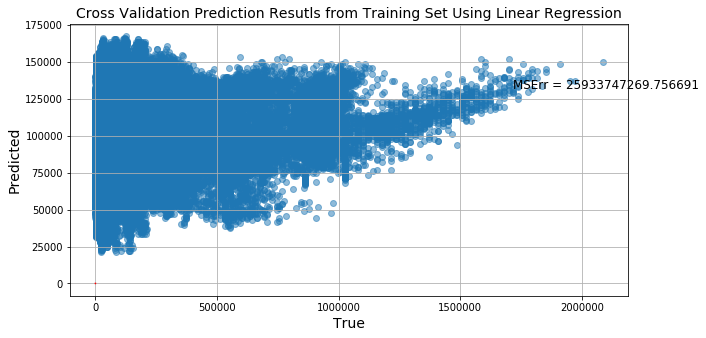

In [385]:
mse = mean_squared_error(y, y_pr)
fig4 = plt.figure(figsize=(10,5))
plt.scatter(y,y_pr,alpha = .5)
plt.plot([0,.6],[0,.6],'r-')
plt.title('Cross Validation Prediction Resutls from Training Set Using Linear Regression',fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('Predicted',fontsize=14)
plt.grid();
fig4.text(0.74, .7, 'MSErr = {:2f}'.format(mse), fontsize=12);

In [ ]:
#set up parameters for the model and cross-validation
model = Lasso(max_iter=5000)
parameters = {'alpha': [1e-5,1e-3,1e-1,1], 'fit_intercept': [True,False]}
grid = GridSearchCV(model,parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1);
#fit to model
grid.fit(X_train, y)
# calculate error
MSE_L = mean_squared_error(y, grid.predict(X_train))

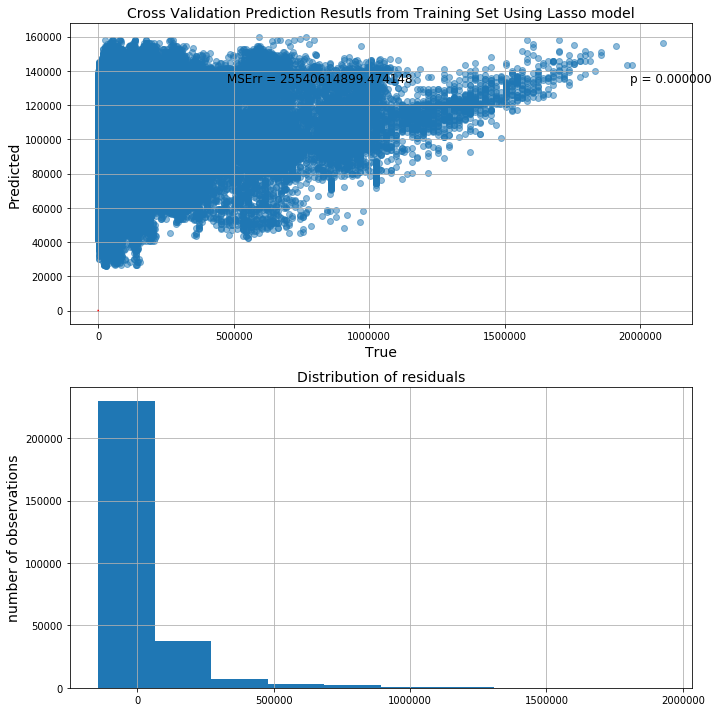

In [391]:
# plot results from the training set 
fig5 = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(y,grid.predict(X_train), alpha=.5);
plt.plot([0,.6],[0,.6],'r-')
plt.title('Cross Validation Prediction Resutls from Training Set Using Lasso model',fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('Predicted',fontsize=14)
plt.grid();
fig5.text(0.32, .88, 'MSErr = {:1f}'.format(MSE_L), fontsize=12);

# plot dist of residuals
plt.subplot(2,1,2)
presiddr = y-grid.predict(X_train)
pdr=normaltest(presiddr)
plt.hist(presiddr);
plt.title('Distribution of residuals',fontsize=14);
plt.ylabel('number of observations',fontsize=14);
fig5.text(0.88, .88, 'p = {:1f}'.format(pdr[1]), fontsize=12);
plt.grid()
plt.tight_layout()

#lasso selects the best feature 

In [396]:
test.dropna(inplace=True)

In [399]:
X_test1 = np.array(test.loc[:,['temperature', 'isweekday']])
y_test = np.array(test.loc[:,'consumption'])   


#stdScale = StandardScaler()
#X_train = X_train1.reshape(-1,1)
X_test = stdScale.fit_transform(X_test1)



# get the best version of the model 
grid.cv_results_
best_lasso = grid.best_estimator_
# fit the test set
lasso_pred = best_lasso.predict(X_test)
# calc residuals
residuals = []
for true,pred in zip(y_test, lasso_pred):
    residuals.append(true - pred)
   # print("pred,residuals:",str(pred) + "," + str(residuals))
# calc errors
MSE_Lt = mean_squared_error(y_test, grid.predict(X_test))
# pvalue
pdr=normaltest(residuals)

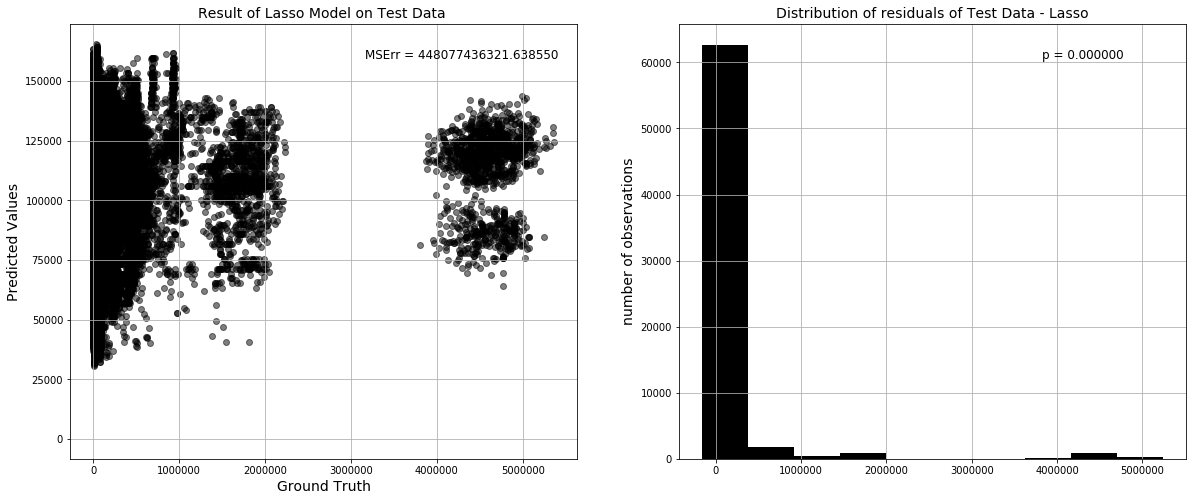

In [400]:
# plot regression results
fig6 = plt.figure(figsize=(20,8));
plt.subplot(1,2,1)
plt.scatter(y_test, best_lasso.predict(X_test),color='k', alpha=.5)
plt.plot([0,.6],[0,.6],'r-')
plt.title('Result of Lasso Model on Test Data ',fontsize=14)
plt.xlabel('Ground Truth',fontsize=14)
plt.ylabel('Predicted Values',fontsize=14)
plt.grid();
fig6.text(0.33, .82, 'MSErr = {:2f}'.format(MSE_Lt), fontsize=12);
 #plot residual dist
plt.subplot(1,2,2)
plt.hist(residuals,color='k');
plt.title('Distribution of residuals of Test Data - Lasso',fontsize=14);
plt.ylabel('number of observations',fontsize=14);
fig6.text(0.80, .82, 'p = {:2f}'.format(pdr[1]), fontsize=12);
plt.grid()

In [343]:
import statsmodels.api as sm

X = np.array(train_meta.loc[:,feature_cols])
y =np.array(train_meta.loc[:,'consumption'])

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                 9.505e+04
Date:                Thu, 04 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:11:31   Log-Likelihood:            -3.7705e+06
No. Observations:              280687   AIC:                         7.541e+06
Df Residuals:                  280686   BIC:                         7.541e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5442.7176     17.654    308.297      0.000    5408.116    5477.319
==============================================================================
Omnibus:                   205387.640   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3956453.507
Skew:                           3.392   Prob(JB):                         0.00
Kurtosis:                      20.096   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [236]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
#using test/train split 
def train_test_rmse(df, feature_cols):
    X = train_meta[feature_cols]
    y = train_meta.consumption
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    y_pred = lr.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [240]:
print(train_test_rmse(train_meta, ['temperature', 'surface_num']))
#print(train_test_rmse(train_meta, ['surface_num']))
#print(train_test_rmse(train_meta, ['temperature']))

223494.2497705493


In [241]:
#comparing RMSE with null RMSE 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_train, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_train.mean())
y_null

np.sqrt(metrics.mean_squared_error(y_train, y_null))

161617.29526088593

## ARIMA

Text(0, 0.5, 'Consumption')

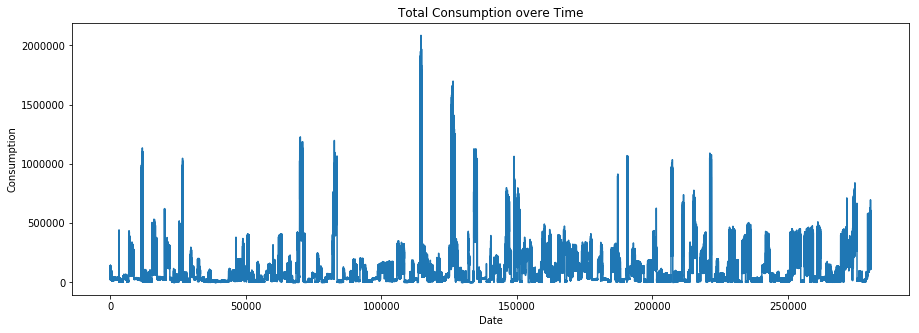

In [243]:
plt.plot(train_meta.index, train_meta['consumption'])
plt.title("Total Consumption overe Time")
plt.xlabel("Date")
plt.ylabel("Consumption")

In [244]:
# differencing
series = train_meta['consumption'].iloc[:20]

lag_series = pd.DataFrame({'Original': series, 
                           'Lag1': series.diff(), 
                           'Lag2':series.diff(2),})
lag_series

,Original,Lag1,Lag2
0,24503.324916,NaN,NaN
1,26592.524360,2089.199445,NaN
2,116047.567727,89455.043366,91544.242811
3,105676.184769,-10371.382958,79083.660409
4,85336.335890,-20339.848880,-30711.231837
5,106676.015932,21339.680042,999.831163
6,113085.381371,6409.365439,27749.045482
7,61922.379256,-51163.002116,-44753.636676
8,37866.739935,-24055.639320,-75218.641436
9,114935.815165,77069.075230,53013.435909


In [245]:
Y = train_meta['consumption'].values.flatten()
size_train = int(0.75*len(Y))
train,test = Y[:size_train], Y[size_train:]

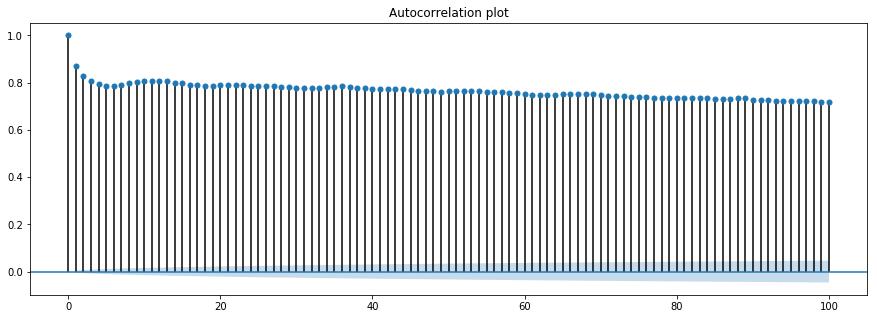

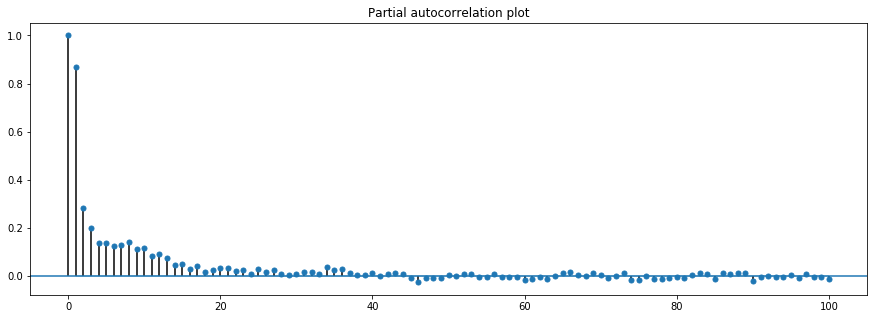

In [251]:
# Plot ACF up to 50 lags, show 95% confidence interval
plot_acf(train, lags = 100)
plt.title('Autocorrelation plot')

# Plot PACF, show 95% confidence interval
plot_pacf(train, lags = 100)
plt.title('Partial autocorrelation plot')

plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:               210514
Model:                 ARIMA(1, 1, 0)   Log Likelihood            -2677337.865
Method:                       css-mle   S.D. of innovations          80753.780
Date:                Wed, 03 Apr 2019   AIC                        5354681.729
Time:                        16:01:11   BIC                        5354712.501
Sample:                             1   HQIC                       5354690.766
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1336    132.199      0.001      0.999    -258.971     259.238
ar.L1.D.y     -0.3314      0.002   -161.140      0.000      -0.335      -0.327
                                    Roots           

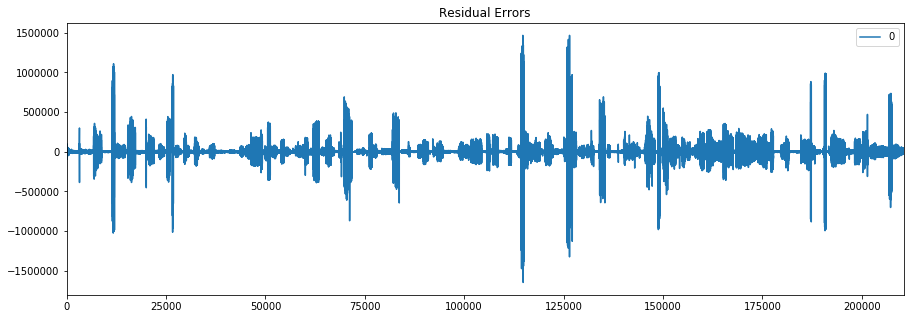

In [248]:
# fit model using statsmodels ARIMA
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("Residual Errors")
plt.show()

Do a stepwise model, fix auto_arima installation issues.

### Supervised Learning Model

In [256]:
feature_cols = ['temperature', 'surface_num']
train_sup = pd.get_dummies(train_meta, columns=feature_cols)

In [257]:
# add time series lags as features using SHIFT operator in Pandas
train_sup['consumption_1'] = train_sup['consumption'].shift(1)
train_sup['consumption_1'].iloc[0] = train_sup['consumption'].iloc[0]

train_sup['consumption_2'] = train_sup['consumption'].shift(2)
train_sup['consumption_2'].iloc[0] = train_sup['consumption'].iloc[0]
train_sup['consumption_2'].iloc[1] = train_sup['consumption'].iloc[0]


C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [259]:
X = train_sup.drop('consumption', axis=1)
y = train_sup['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                        y,
                                        test_size=0.25,
                                        shuffle=False, # do not shuffle time series
                                        random_state=42)

In [265]:
# try default random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train.values, y_train.values)
#print("Default Random Forest R2:", rf.score(X_test.values,y_test.values))

MemoryError: 

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

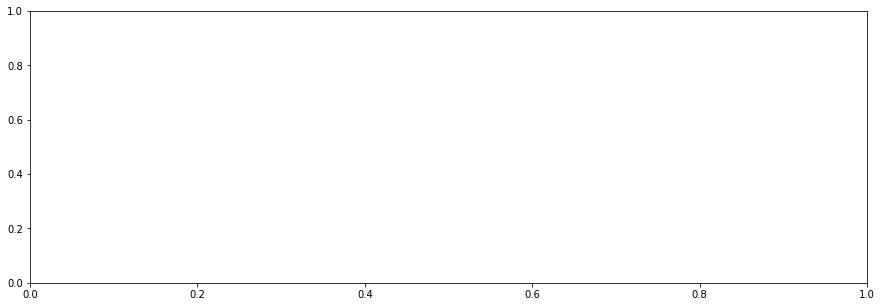

In [263]:
### Plot the forecast
fig, ax = plt.subplots()
ax.plot(rf.predict(X_test), label='Predicted')
ax.plot(y_test.values, label='Actual')
plt.title("Actual vs. Predicted counts using Random Forest")
plt.xlabel("Index")
plt.ylabel("Counts")
plt.legend()
plt.show()